# House Price Challenge

The housing market is one of the most crucial parts of every country's economy. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a central topic in economic and financial circles.

The [houseprices dataset from Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview) includes several features of the houses, along with their sale prices at the time that they are sold. So far in this module, we have built and implemented some models using this dataset.

In this challenge, we are required to improve our model with respect to its prediction performance. We will perform the following tasks:

1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. We can use our previous work in this module. But, make sure that our work is satisfactory.
3. Now, split the data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including lasso, ridge, or elastic net, and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if the models include one.
5. Evaluate your best model on the test set.
6. So far, we have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.


First, we load create a database connection to house price data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sqlalchemy import create_engine, text

import warnings
warnings.filterwarnings('ignore')

# Read the full contents of the dataframes
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, our task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).


### 1. Load the houseprices data from Thinkful's database.

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_price_df = pd.read_sql_query(text('SELECT * FROM houseprices'), con=engine.connect())

# No need for an open connection, because you're only doing a single query
engine.dispose()

### 2. Do data cleaning, exploratory data analysis, and feature engineering. We can use our previous work in this module. But, make sure that our work is satisfactory.

Let's first classify which columns are numerical and which are non-numerical.

In [3]:
# Numerical
numeric_columns = house_price_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


In [4]:
# Non-Numerical
non_numeric_columns = house_price_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numeric columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numeric columns is 43


We need to address the columns with missing values. These are

In [5]:
missing_mask = house_price_df.isna()
total_missing = missing_mask.sum().sort_values(ascending=False)
percent_missing = (missing_mask.sum() / missing_mask.count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total Missing', 'Percent Missing'])
missing_data.head(19)

,Total Missing,Percent Missing
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garageyrblt,81,0.055479
garagecond,81,0.055479
garagetype,81,0.055479
garagefinish,81,0.055479


We will drop the first five: `poolqc`,`miscfeature`, `alley`, `fence`, and `electrical`. We will also drop the `id` column.

In [6]:
house_price_df.drop(columns=['id','alley','electrical','poolqc','fence','miscfeature'],inplace=True)

Next, we define a function to clean the remaining numerical and non-numerical columns.

In [7]:
def clean_null_columns(df):
  for col in df:
    feature = df[col]
    if col in numeric_columns and feature.isnull().values.any():
      feature.fillna(feature.mean(), inplace=True)
    elif col in non_numeric_columns and feature.isnull().values.any():
      for i in range(0, len(feature)):
        most_freq_val = feature.value_counts().idxmax()
        if pd.isnull(feature[i]):
            feature[i] = most_freq_val

clean_null_columns(house_price_df)

We also remove outliers from our target variable.

In [8]:
# Remove large outliers from the dataset before training.
outlier = house_price_df['saleprice'].quantile(.99)
house_price_df = house_price_df[house_price_df['saleprice'] < outlier]

Next, let's define a new function to look at a correlation map of the features of interest and the target variable.

In [9]:
def heatmap_features_and_target(df, n_cols):
  corr = df.corr()
  correlated_columns = corr['saleprice'].sort_values(ascending=False).head(n_cols).index
  corr_of_correlated_columns = df[correlated_columns].corr()

  fig=plt.figure(figsize=(15,10))
  sns.heatmap(corr_of_correlated_columns,cmap='Blues',annot=True)

We can now examine a correlation matrix between the top 20 features and  `saleprice`.

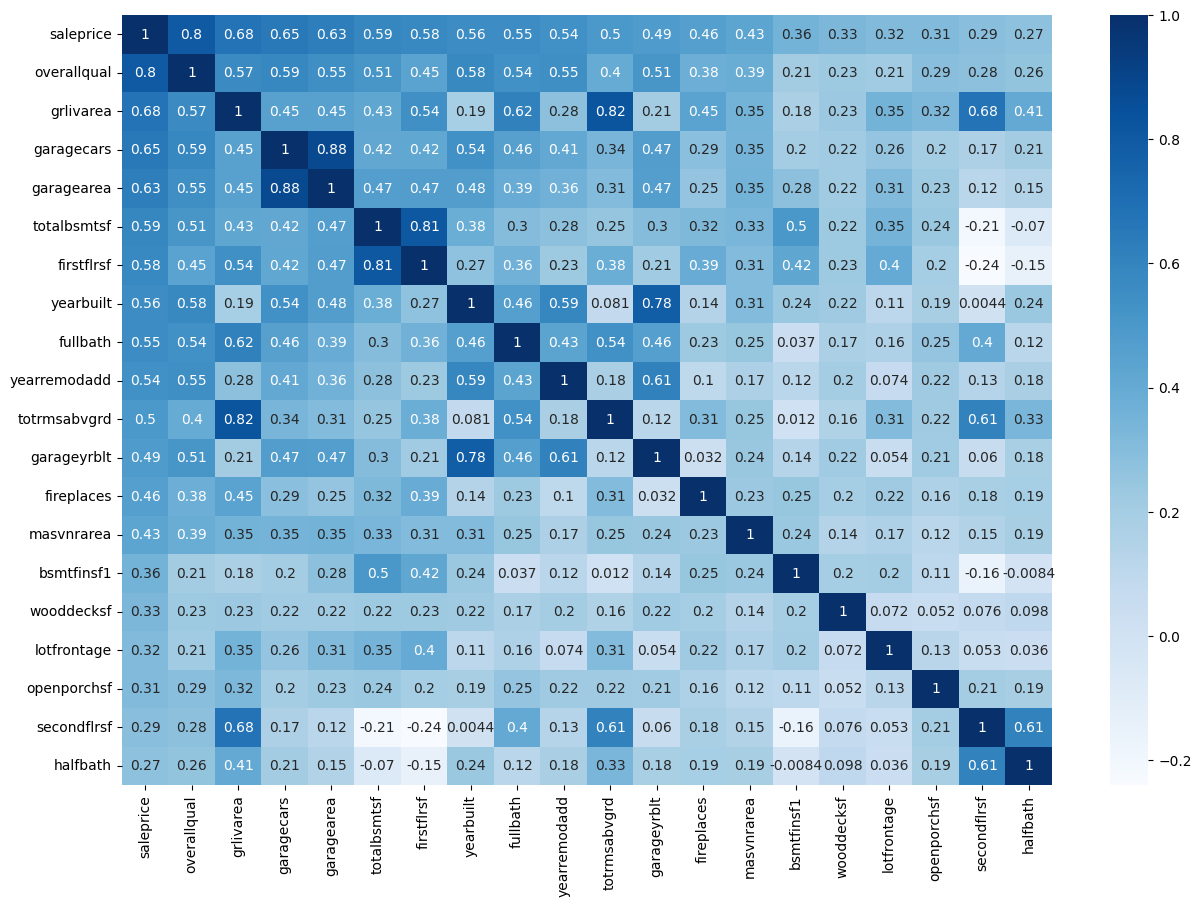

In [10]:
heatmap_features_and_target(house_price_df, 20)

We previously found that the non-numerical features `mszoning`,`street`,`utilities`,`bsmtqual`, and `salecondition` are important to the sale price. Therefore, we will turn them into dummy variables.

In [11]:
dummy_column_names = []
def convert_to_dummy(df, names, dummy_column_names):
  for name in names:
    df = pd.concat([df,pd.get_dummies(df[name], prefix=name, drop_first=True)], axis=1)
  for name in names:
    dummy_column_names = dummy_column_names + list(pd.get_dummies(df[name], prefix=name, drop_first=True).columns)
  return df, dummy_column_names

house_price_df, dummy_column_names = convert_to_dummy(house_price_df, ['mszoning','street','utilities','bsmtqual','salecondition'], dummy_column_names)

 We also found that we can improve the model by increasing the goodness of fit. To do this, we execute the steps below:

- We first log transform the dependent variable. Recall from the histogram above that the `saleprice` variable is not normally distributed, so log transforming may help in this regard. To this end, we apply `log(1+x)` transformation of NumPy.
- Second, we create another variable by summing up the basement, first and the second floor areas.
- Third, we add the interaction of the total area and the overall quality of the house.
- Fourth, we drop the explanatory variable that aren't statistically significant.

In [12]:
house_price_reduced_df = house_price_df.copy()
unwanted_features = ['mszoning_FV','mszoning_RH',
                     'mszoning_RM','street_Pave',
                    'utilities_NoSeWa','salecondition_AdjLand',
                    'salecondition_Alloca','salecondition_Family']
dummy_column_names_reduced = [e for e in dummy_column_names if e not in unwanted_features]

We now finish creating the new dataframe with the numerical variables `overallqual`, `grlivarea`, `garagecars`, `garagearea`, and `totalbsmtsf`. We also include the steps performed to increase the goodness of fit.

In [13]:
house_price_reduced_df['totalsf'] = house_price_reduced_df['totalbsmtsf'] + house_price_reduced_df['firstflrsf'] + house_price_reduced_df['secondflrsf']
house_price_reduced_df['int_over_sf'] = house_price_reduced_df['totalsf'] * house_price_reduced_df['overallqual']
house_price_reduced_df = house_price_reduced_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'totalsf', 'int_over_sf'] + dummy_column_names_reduced]

We visualize these changes through a new heatmap.

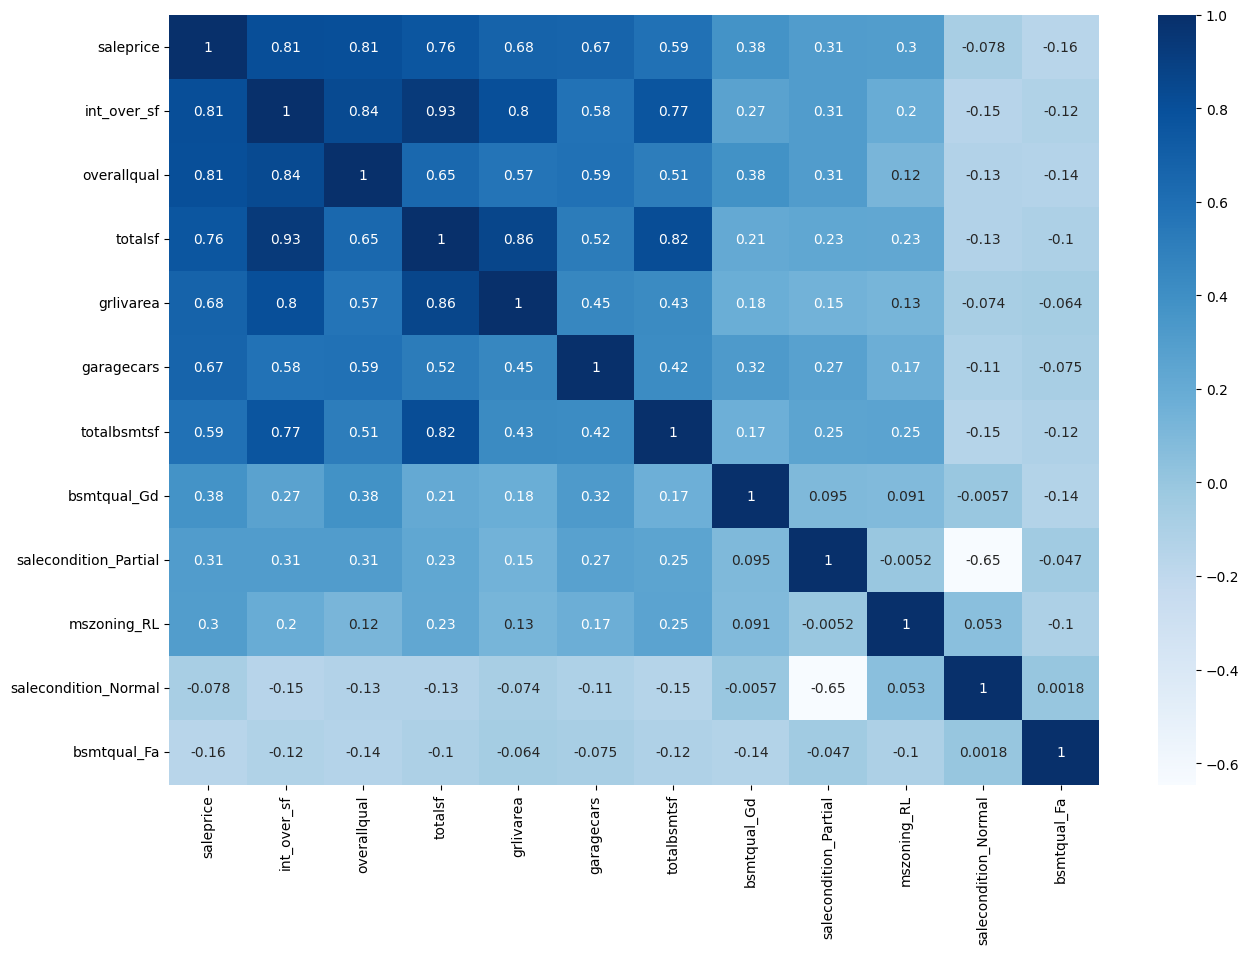

In [14]:
corr_df = house_price_reduced_df.copy()
corr_df['saleprice'] = np.log1p(house_price_df['saleprice'])
heatmap_features_and_target(corr_df, 12)

### 3. Now, split your data into train and test sets where 20% of the data resides in the test set.

In [15]:
# Y is the target variable
Y = np.log1p(house_price_df['saleprice'])
# X is the feature set
X = house_price_reduced_df

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1156
The number of observations in test set is 289


Let's also create a scaled version of our dataset to compare results.

In [24]:
for categorical in house_price_df.describe(exclude=np.number).columns:
    house_df = pd.concat([house_price_df, pd.get_dummies(house_price_df[categorical],drop_first=True,prefix=categorical)], axis=1)

# This grabs just the continuous variables from our dataset.
all_house_df = house_df[house_df.describe(include=np.number).columns]

# Then, concatenate dummy versions of the categorical variables.
# We do this column by column because trying to do it all in one shot introduced
# a lot of duplicate columns with NaNs in them.
for column in house_df.describe(exclude=np.number).columns:
    all_house_df = pd.concat([all_house_df,pd.get_dummies(house_df[column],drop_first=True,prefix=column)],axis=1)
all_house_df.head()

,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,utilities_NoSeWa,bsmtqual_Fa,bsmtqual_Gd,bsmtqual_TA,salecondition_AdjLand,salecondition_AdjLand,salecondition_Alloca,salecondition_Alloca,salecondition_Family,salecondition_Family,salecondition_Normal,salecondition_Normal,salecondition_Partial,salecondition_Partial,salecondition_AdjLand,salecondition_AdjLand,salecondition_Alloca,salecondition_Alloca,salecondition_Family,salecondition_Family,salecondition_Normal,salecondition_Normal,salecondition_Partial,salecondition_Partial,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,lotshape_IR2,lotshape_IR3,lotshape_Reg,landcontour_HLS,landcontour_Low,landcontour_Lvl,utilities_NoSeWa,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,landslope_Mod,landslope_Sev,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,condition1_Feedr,condition1_Norm,condition1_PosA,condition1_PosN,condition1_RRAe,condition1_RRAn,condition1_RRNe,condition1_RRNn,condition2_Feedr,condition2_Norm,condition2_PosA,condition2_PosN,condition2_RRAe,condition2_RRAn,condition2_RRNn,bldgtype_2fmCon,bldgtype_Duplex,bldgtype_Twnhs,bldgtype_TwnhsE,housestyle_1.5Unf,housestyle_1Story,housestyle_2.5Fin,housestyle_2.5Unf,housestyle_2Story,housestyle_SFoyer,housestyle_SLvl,roofstyle_Gable,roofstyle_Gambrel,roofstyle_Hip,roofstyle_Mansard,roofstyle_Shed,roofmatl_CompShg,roofmatl_Membran,roofmatl_Metal,roofmatl_Roll,roofmatl_Tar&Grv,roofmatl_WdShake,roofmatl_WdShngl,exterior1st_AsphShn,exterior1st_BrkComm,exterior1st_BrkFace,exterior1st_CBlock,exterior1st_CemntBd,exterior1st_HdBoard,exterior1st_ImStucc,exterior1st_MetalSd,exterior1st_Plywood,exterior1st_Stone,exterior1st_Stucco,exterior1st_VinylSd,exterior1st_Wd Sdng,exterior1st_WdShing,exterior2nd_AsphShn,exterior2nd_Brk Cmn,exterior2nd_BrkFace,exterior2nd_CBlock,exterior2nd_CmentBd,exterior2nd_HdBoard,exterior2nd_ImStucc,exterior2nd_MetalSd,exterior2nd_Other,exterior2nd_Plywood,exterior2nd_Stone,exterior2nd_Stucco,exterior2nd_VinylSd,exterior2nd_Wd Sdng,exterior2nd_Wd Shng,masvnrtype_BrkFace,masvnrtype_None,masvnrtype_Stone,exterqual_Fa,exterqual_Gd,exterqual_TA,extercond_Fa,extercond_Gd,extercond_Po,extercond_TA,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,bsmtqual_Fa,bsmtqual_Gd,bsmtqual_TA,bsmtcond_Gd,bsmtcond_Po,bsmtcond_TA,bsmtexposure_Gd,bsmtexposure_Mn,bsmtexposure_No,bsmtfintype1_BLQ,bsmtfintype1_GLQ,bsmtfintype1_LwQ,bsmtfintype1_Rec,bsmtfintype1_Unf,bsmtfintype2_BLQ,bsmtfintype2_GLQ,bsmtfintype2_LwQ,bsmtfintype2_Rec,bsmtfintype2_Unf,heating_GasA,heating_GasW,heating_Grav,heating_OthW,heating_Wall,heatingqc_Fa,heatingqc_Gd,heatingqc_Po,heatingqc_TA,centralair_Y,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sev,functional_Typ,fireplacequ_Fa,fireplacequ_Gd,fireplacequ_Po,fireplacequ_TA,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagefinish_RFn,garagefinish_Unf,garagequal_Fa,garagequal_Gd,garagequal_Po,garagequal_TA,garagecond_Fa,garagecond_Gd,garagecond_Po,garagecond_TA,paveddrive_P,pavedd

In [25]:
all_house_df['log_saleprice'] = np.log(all_house_df['saleprice'])
all_house_df = all_house_df.drop(columns=['saleprice'])

# Scale the features so we can more easily determine which are the most significant
scaler = StandardScaler()
scaled_all_house_arr = scaler.fit_transform(all_house_df)

scaled_all_house_df = pd.DataFrame(scaled_all_house_arr,columns=all_house_df.columns)

# How does it look if we use the scaled version of the "all" dataset instead?
X_scaled = scaled_all_house_df.drop(columns=['log_saleprice'])
Y_scaled = scaled_all_house_df['log_saleprice']

Xscl_train, Xscl_test, yscl_train, yscl_test = train_test_split(X_scaled, Y_scaled,
                                                                test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(Xscl_train.shape[0]))
print("The number of observations in test set is {}".format(Xscl_test.shape[0]))

The number of observations in training set is 1156
The number of observations in test set is 289


### 4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one.

In [26]:
# Capture k-fold output in a dataframe for comparisons
kfold_df = pd.DataFrame(columns=['Model','Fold_1','Fold_2','Fold_3','Fold_4','Fold_5'])

We also define two helper functions.

In [27]:
# Returns a dictonary of statistics to compare various model performance
# provided that five folds are defined.
def kfold_xval(model,train_data,target_data,**kwargs):
    num_folds = kwargs.get('num_folds',10)
    ret_5 = kwargs.get('ret_5',num_folds==5)
    print("Cross-validation using {} folds".format(num_folds))
    cross_val_array = cross_val_score(model, train_data, target_data, cv=num_folds)
    if ret_5:
        ret_dict = {'Model': str(model),
                    'Fold_1': cross_val_array[0],
                    'Fold_2': cross_val_array[1],
                    'Fold_3': cross_val_array[2],
                    'Fold_4': cross_val_array[3],
                    'Fold_5': cross_val_array[4],
                   }
        print(ret_dict)
        return(ret_dict)
    else:
        print(cross_val_array)

In [28]:
def comp_train_test(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)

    # We are making predictions here
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)

    # Low alpha helps us understand whether there is a concentration of observations
    # at a particular point, or if it is an outlier
    tips = sns.load_dataset("tips")
    ax = sns.regplot(data=tips,x=y_test,y=y_preds_test,scatter_kws={"color": "blue", 'alpha':0.3}, line_kws={"color": "red"})
    ax.set(xlabel='Test value', ylabel='Predicted value',title='Test values vs. predicted values,\n{}'.format(str(model)))
    plt.show()

    print("R-squared of the model on the training set is: {}".format(model.score(X_train, y_train)))
    print("-----Test set statistics-----")
    print("R-squared of the model on the test set is: {}".format(model.score(X_test, y_test)))
    print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
    print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

### Linear Regression

In [29]:
linear = LinearRegression()
cv_results = kfold_xval(linear,X_train,y_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'LinearRegression()', 'Fold_1': 0.8334634168478642, 'Fold_2': 0.8050955684609289, 'Fold_3': 0.8395548798722722, 'Fold_4': 0.7187132448404014, 'Fold_5': 0.8794206323090445}


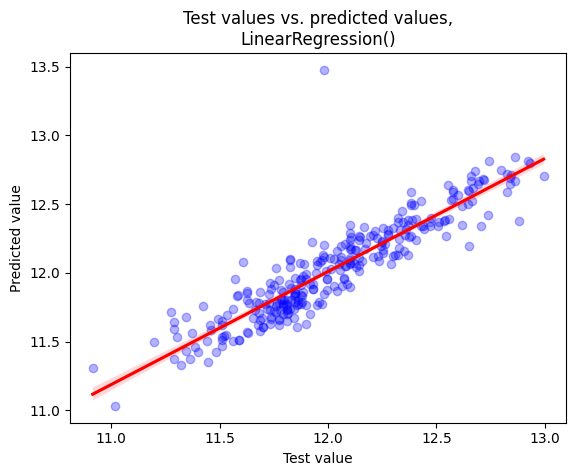

R-squared of the model on the training set is: 0.8303562153410899
-----Test set statistics-----
R-squared of the model on the test set is: 0.8232639369278811
Mean absolute error of the prediction is: 0.11358756947836365
Mean squared error of the prediction is: 0.027786743321703274
Root mean squared error of the prediction is: 0.16669356112850692
Mean absolute percentage error of the prediction is: 0.9467869510550982


In [30]:
comp_train_test(linear,X_train,y_train,X_test,y_test)

Next, let's try the scaled features.

In [31]:
linear_scl = LinearRegression()
cv_results = kfold_xval(linear_scl,Xscl_train,yscl_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'LinearRegression()', 'Fold_1': -9.806478200498612e+23, 'Fold_2': -4.99379879199835e+25, 'Fold_3': -4.055999728422952e+20, 'Fold_4': -1.0509963951333797e+23, 'Fold_5': -6.013295639678082e+16}


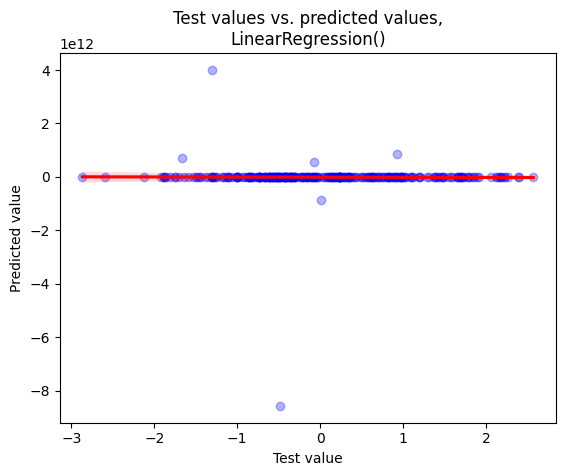

R-squared of the model on the training set is: 0.9392111600346792
-----Test set statistics-----
R-squared of the model on the test set is: -2.957756363894775e+23
Mean absolute error of the prediction is: 53944965828.15679
Mean squared error of the prediction is: 3.180760633788594e+23
Root mean squared error of the prediction is: 563982325413.5358
Mean absolute percentage error of the prediction is: 70659998679105.33


In [32]:
comp_train_test(linear_scl,Xscl_train,yscl_train,Xscl_test,yscl_test)

### Ridge Regression

In [33]:
ridge = Ridge()
cv_results = kfold_xval(ridge,X_train,y_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'Ridge()', 'Fold_1': 0.8328883741517896, 'Fold_2': 0.8053030773817155, 'Fold_3': 0.8400927322220886, 'Fold_4': 0.7181901321438706, 'Fold_5': 0.8794544891835181}


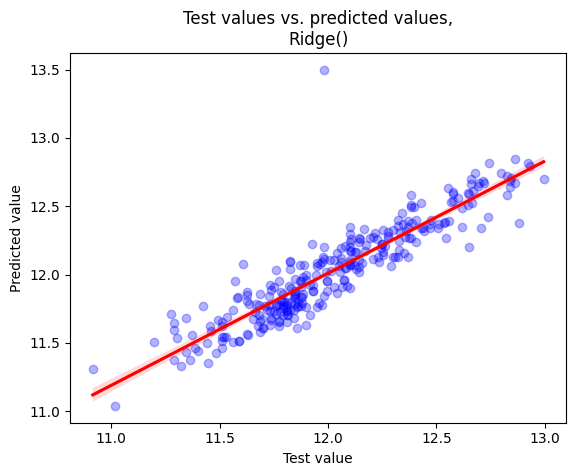

R-squared of the model on the training set is: 0.8303189956861483
-----Test set statistics-----
R-squared of the model on the test set is: 0.8217167869684239
Mean absolute error of the prediction is: 0.11380587029580423
Mean squared error of the prediction is: 0.02802998886002943
Root mean squared error of the prediction is: 0.16742159018486663
Mean absolute percentage error of the prediction is: 0.9486320183918342


In [34]:
comp_train_test(ridge,X_train,y_train,X_test,y_test)

We will once again try the scaled features.

In [35]:
ridge_scl = Ridge()
cv_results = kfold_xval(ridge_scl,Xscl_train,yscl_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'Ridge()', 'Fold_1': 0.8992606538650025, 'Fold_2': 0.8059994333748164, 'Fold_3': 0.8752754905966319, 'Fold_4': 0.7559017892571317, 'Fold_5': 0.888583493479604}


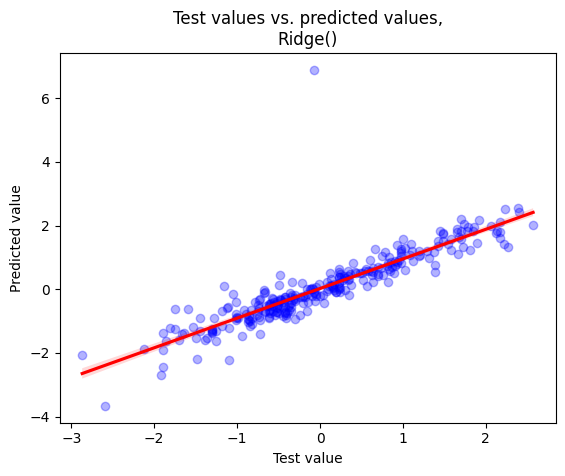

R-squared of the model on the training set is: 0.939192947641245
-----Test set statistics-----
R-squared of the model on the test set is: 0.7422239006286855
Mean absolute error of the prediction is: 0.265356961041335
Mean squared error of the prediction is: 0.2772114969375563
Root mean squared error of the prediction is: 0.5265087814439151
Mean absolute percentage error of the prediction is: 103.76828797764466


In [36]:
comp_train_test(ridge_scl,Xscl_train,yscl_train,Xscl_test,yscl_test)

### Lasso Regression

In [37]:
lasso = Lasso()
cv_results = kfold_xval(lasso,X_train,y_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'Lasso()', 'Fold_1': 0.7573675430806538, 'Fold_2': 0.7203965464428963, 'Fold_3': 0.7540199904271081, 'Fold_4': 0.47664023042451764, 'Fold_5': 0.7973990063943873}


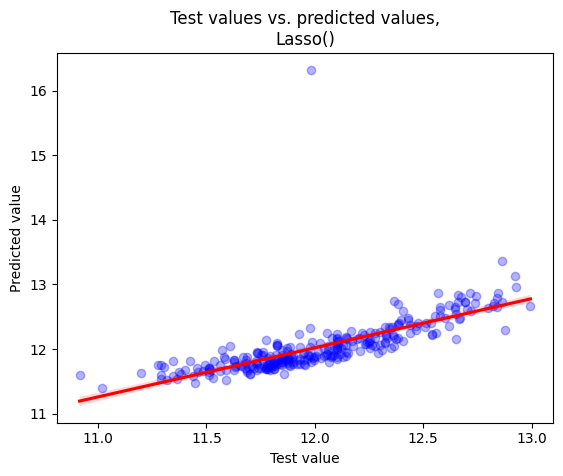

R-squared of the model on the training set is: 0.7186817427273016
-----Test set statistics-----
R-squared of the model on the test set is: 0.38036382421463377
Mean absolute error of the prediction is: 0.15364786606503908
Mean squared error of the prediction is: 0.09742024955237312
Root mean squared error of the prediction is: 0.31212217087604194
Mean absolute percentage error of the prediction is: 1.2836014190805392


In [38]:
comp_train_test(lasso,X_train,y_train,X_test,y_test)

Again, we try the scaled features.

In [39]:
lasso_scl = Lasso()
cv_results = kfold_xval(lasso_scl,Xscl_train,yscl_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'Lasso()', 'Fold_1': -0.007619201264994269, 'Fold_2': -0.0002959776575672812, 'Fold_3': -9.98826269693609e-06, 'Fold_4': -0.01681576835288645, 'Fold_5': -0.0015350792040571548}


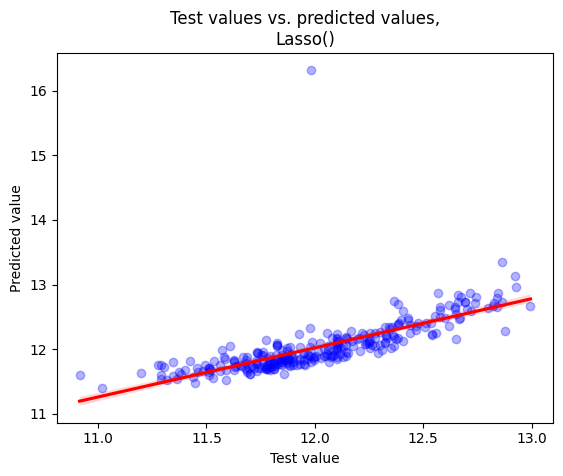

R-squared of the model on the training set is: 0.7186817427273016
-----Test set statistics-----
R-squared of the model on the test set is: 0.38036382421463377
Mean absolute error of the prediction is: 0.15364786606503908
Mean squared error of the prediction is: 0.09742024955237312
Root mean squared error of the prediction is: 0.31212217087604194
Mean absolute percentage error of the prediction is: 1.2836014190805392


In [40]:
comp_train_test(lasso,X_train,y_train,X_test,y_test)

### Elastic Net Regression.

Shifting the ratio to .01 to favor the Ridge penalty over the Lasso penalty appears to yield good results.

In [41]:
elastic = ElasticNet(l1_ratio=.01)
cv_results = kfold_xval(elastic,X_train,y_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'ElasticNet(l1_ratio=0.01)', 'Fold_1': 0.7804832528031598, 'Fold_2': 0.7461109211440118, 'Fold_3': 0.7805504749509815, 'Fold_4': 0.526508824615692, 'Fold_5': 0.8259970489930781}


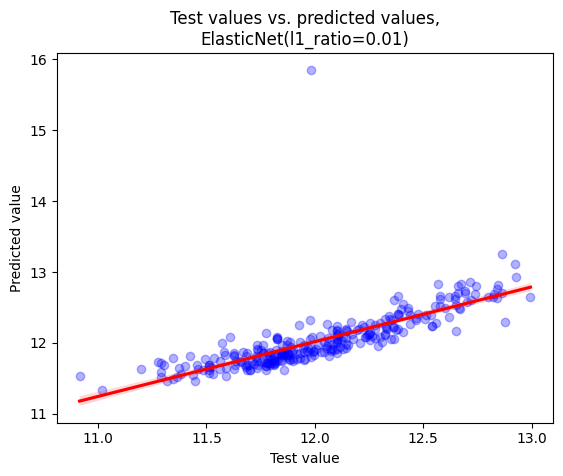

R-squared of the model on the training set is: 0.7502436192512713
-----Test set statistics-----
R-squared of the model on the test set is: 0.4888952576419491
Mean absolute error of the prediction is: 0.14328487755091793
Mean squared error of the prediction is: 0.08035675367858117
Root mean squared error of the prediction is: 0.2834726683096294
Mean absolute percentage error of the prediction is: 1.1967413791362773


In [42]:
comp_train_test(elastic,X_train,y_train,X_test,y_test)

In [43]:
elastic_scl = ElasticNet(l1_ratio=.01)
cv_results = kfold_xval(elastic_scl,Xscl_train,yscl_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'ElasticNet(l1_ratio=0.01)', 'Fold_1': 0.8636505301137352, 'Fold_2': 0.8566735163820858, 'Fold_3': 0.8792182115843323, 'Fold_4': 0.8092455161354177, 'Fold_5': 0.8726387738890247}


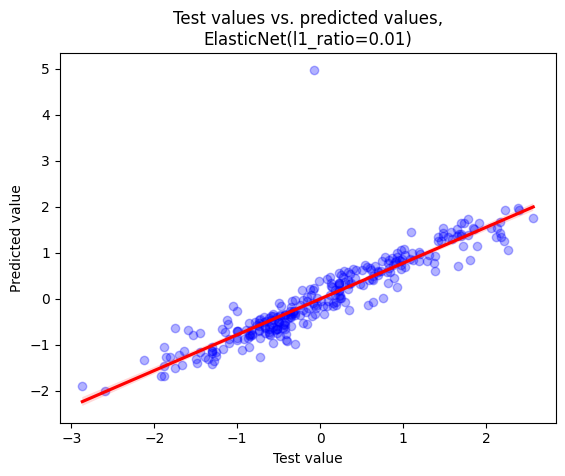

R-squared of the model on the training set is: 0.8856912583166955
-----Test set statistics-----
R-squared of the model on the test set is: 0.8123097783531262
Mean absolute error of the prediction is: 0.26552798939229166
Mean squared error of the prediction is: 0.20184139425713382
Root mean squared error of the prediction is: 0.44926761986274266
Mean absolute percentage error of the prediction is: 90.66569677581056


In [44]:
comp_train_test(elastic_scl,Xscl_train,yscl_train,Xscl_test,yscl_test)

### 5. Evaluate your best model on the test set.

We can compare our scores on cross validation.

In [51]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
kfold_df['avg_score'] = kfold_df.mean(axis=1)
kfold_df.sort_values(['avg_score'],ascending=False)

,Model,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,avg_score
7,ElasticNet(l1_ratio=0.01),0.864,0.857,0.879,0.809,0.873,0.856
3,Ridge(),0.899,0.806,0.875,0.756,0.889,0.845
0,LinearRegression(),0.833,0.805,0.840,0.719,0.879,0.815
2,Ridge(),0.833,0.805,0.840,0.718,0.879,0.815
6,ElasticNet(l1_ratio=0.01),0.780,0.746,0.781,0.527,0.826,0.732
4,Lasso(),0.757,0.720,0.754,0.477,0.797,0.701
5,Lasso(),-0.008,-0.000,-0.000,-0.017,-0.002,-0.005
1,LinearRegression(),-980647820049861247500288.000,-49937987919983497921429504.000,-405599972842295197696.000,-105099639513337967935488.000,-60132956396780816.000,-10204828207930496788725760.000
